The size and composition of binding sites will be analyzed in more detail.

In [7]:
import base_defs as base
from importlib import reload; reload(base)
import zipfile
import time
import MDAnalysis as mda
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import shutup
from io import BytesIO
from io import StringIO
import gzip as gz
import warnings
import os
import re
import random
import pickle
from matplotlib import pyplot as plt
from rdkit import Chem
from scipy.spatial import ConvexHull, convex_hull_plot_2d, distance
import base_defs_stats as bstat
import ast

zip_path_virus = "/media/andrej/KEYCHAIN II/bsr_data/ProBiS_Dock_DB_bs_id1division_id9.zip"


## Loading individual binding sites

First problem: Loading individual binding sites

Currently, the statistics workflow is optimized to merge selections of all binding site regions for a given chain, we will need to undo this optimization.

The first step is to retrieve all selections associated with a given chain individually.

In [170]:
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     reload(base)
#     with zipfile.ZipFile(zip_path_virus, 'r') as probis_zip:
#         pdb_dict = base.get_file_name_dict(probis_zip, ["2nnk","3pu0","1ar6"])#,"3pu0","1ar6","1a1r"])

#         regions_organized = {}
#         for pdb_id in pdb_dict:
#             regions_organized[pdb_id] = {}
#             chain_dict = base.get_chain_dict(pdb_dict[pdb_id])
#             for chain in chain_dict:
#                 regions_organized[pdb_id][chain] = base.collect_chain_by_filegroup(chain_dict[chain], probis_zip, cutoff = 10, cb_only=False, stats_only=False)


## Binding site as convex hull

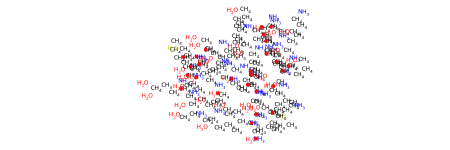

In [171]:
test_bsite = regions_organized["2nnk"]["A"][0]["bsite"]

test_bsite.atoms.convert_to("RDKIT",NoImplicit=False)

In [172]:
test_bsite_points = test_bsite.positions

test_bsite_hull = ConvexHull(test_bsite_points)

x,y,z = test_bsite_hull.points.T
fig = go.Figure()
fig.add_trace(go.Mesh3d(x=x, y=y, z=z, color="blue", opacity=.5, alphahull=0))
fig

In [173]:
test_bsite_hull.volume

2895.913091289973

## Drawing selections

/home/andrej/miniconda3/envs/bsiteaa/lib/python3.12/site-packages/rdkit/Chem/Draw/IPythonConsole.py:261: UserWarning:

Truncating the list of molecules to be displayed to 9. Change the maxMols value to display more.



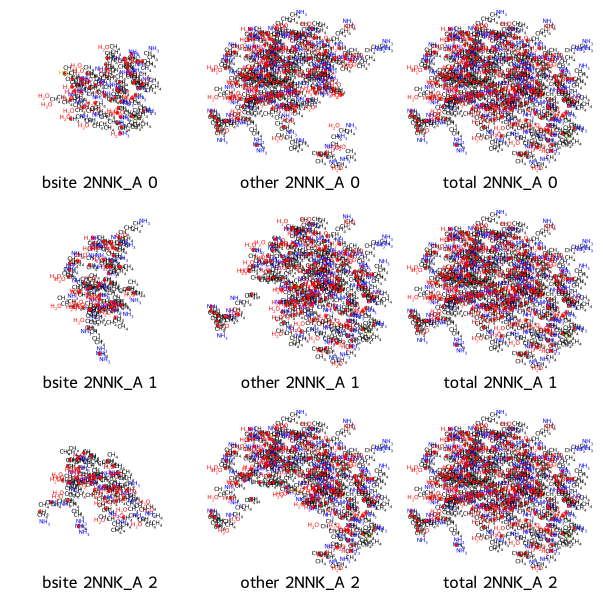

In [174]:
region_types = ["bsite", "other", "total"]

mols = [regions[region_type].atoms.convert_to("RDKIT",NoImplicit=False) for pdb_id in regions_organized for chain_id in regions_organized[pdb_id] for regions in regions_organized[pdb_id][chain_id] for region_type in region_types]

legends = [region_type+" "+pdb_id.upper()+"_"+chain_id+" "+str(i) for pdb_id in regions_organized for chain_id in regions_organized[pdb_id] for i, regions in enumerate(regions_organized[pdb_id][chain_id]) for region_type in region_types]


Chem.Draw.MolsToGridImage(mols=mols, legends = legends, molsPerRow=3, maxMols=9)

In [175]:
regions_organized["2nnk"]["A"][0]

{'bsite_index': 0,
 'bsite_hull_volume': 2895.91,
 'total_hull_volume': 17128.83,
 'avg_bsite_rasa': 0.32,
 'top_AAs': array(['ARG', 'GLU', 'LYS', 'VAL'], dtype=object),
 'num_bsite_aa': 24,
 'num_other_aa': 75,
 'total': <AtomGroup with 755 atoms>,
 'bsite': <AtomGroup with 202 atoms>,
 'other': <AtomGroup with 553 atoms>}

## Aggregating the data

In [180]:
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     reload(base)
#     with zipfile.ZipFile(zip_path_virus, 'r') as probis_zip:
#         pdb_dict = base.get_file_name_dict(probis_zip, ["2nnk","3pu0","1ar6"])#,"3pu0","1ar6","1a1r"])

#         stats = {}
#         for pdb_id in pdb_dict:
#             stats[pdb_id] = {}
#             chain_dict = base.get_chain_dict(pdb_dict[pdb_id])
#             for chain in chain_dict:
#                 stats[pdb_id][chain] = base.collect_chain_by_filegroup(chain_dict[chain], probis_zip, cutoff = 10, cb_only=False, stats_only=True)


In [212]:
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     reload(base)
#     with zipfile.ZipFile(zip_path_virus, 'r') as probis_zip:
#         pdb_dict = base.get_file_name_dict(probis_zip, ["2nnk","3pu0","1ar6"])#,"3pu0","1ar6","1a1r"])
#         res = base.collect_stats_for_pdbs(pdb_dict, probis_zip, cutoff=10, num_top_aas=4)

### Processing cluster data

In [89]:
# reload(bstat)
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     with zipfile.ZipFile(zip_path_virus, 'r') as probis_zip:
#         pdb_dict = bstat.get_file_name_dict(probis_zip)
#         probis_process_res = bstat.probis_process(probis_zip, pdb_dict, ["3pu0","1ar6","1a1r"])
    
# probis_process_res

pdb_id chain_id    bsite_id  avg_bsite_rasa                    top_aas  \
0   3pu0        C  compound_2            0.29  [GLN, LYS, SER, TYR, ASP]   
1   3pu0        B  compound_2            0.33  [GLN, LYS, SER, TYR, ASP]   
2   3pu0        E  compound_2            0.34  [GLN, LYS, SER, TYR, ASP]   
3   3pu0        D  compound_2            0.39  [GLN, LYS, SER, TYR, ASP]   
4   1ar6        4  compound_2            0.97            [GLY, SER, SER]   
5   1ar6        1  compound_2            0.26  [ILE, CYS, THR, LYS, TYR]   
6   1ar6        1  compound_3            0.34  [GLN, TYR, ASP, TRP, ARG]   
7   1a1r        A  compound_2            0.36  [ILE, SER, PRO, TYR, GLY]   
8   1a1r        A  compound_3            0.48  [ALA, THR, SER, THR, GLN]   

   num_bsite_aa  num_other_aa  bsite_hull_volume  total_hull_volume  
0            13           400            1291.07          130755.88  
1            11           404             884.82          132240.01  
2            13           408            1477.25          133971.96  
3            13           403            1482.05          132724.04  
4             3             2              44.42             157.13  
5            27           256            3605.78          117962.52  
6            21           262            3064.46          117962.52  
7            22           130            2478.38           24992.99  
8            12           140            1392.38           24992.99

In [5]:
path = "./data/stats_virus_out/"
files = os.listdir(path)
#all_AAs=["ALA", "ARG", "ASN", "ASP", "CYS", "GLN", "GLU", "GLY", "HIS", "ILE", "LEU", "LYS", "MET", "PHE", "PRO", "SER", "THR", "TRP", "TYR", "VAL"]
categories = ["pdb_id", "chain_id", "bsite_id", "avg_bsite_rasa", "top_aas", "num_bsite_aa", "num_other_aa", "bsite_hull_volume", "total_hull_volume"]

per_bsite_df = pd.concat([pd.read_csv(path+file, sep="\t")[categories] for file in files])
per_bsite_df = per_bsite_df[per_bsite_df["bsite_hull_volume"]!=0].reset_index().drop("index", axis=1)


In [9]:
test_per_bsite_df = per_bsite_df.iloc[0:100]

In [15]:
ast.literal_eval("['THR' 'GLN' 'PRO' 'GLY' 'LEU']".replace('\' \'', '\',\''))

['THR', 'GLN', 'PRO', 'GLY', 'LEU']

In [17]:
test_per_bsite_df['top_aas'].apply(lambda x: [sorted(ast.literal_eval(x.replace('\' \'', '\',\''))[0:i]) for i, y in enumerate(x, start=1)])

0     [[THR], [GLN, THR], [GLN, PRO, THR], [GLN, GLY...
1     [[LYS], [LYS, TRP], [ALA, LYS, TRP], [ALA, LYS...
2     [[ASP], [ASP, ILE], [ARG, ASP, ILE], [ARG, ASN...
3     [[GLN], [GLN, GLN], [GLN, GLN, GLY], [GLN, GLN...
4     [[ASN], [ASN, GLN], [ASN, CYS, GLN], [ASN, CYS...
                            ...                        
95    [[ILE], [ILE], [ILE], [ILE], [ILE], [ILE], [ILE]]
96    [[HIS], [ASP, HIS], [ASP, GLY, HIS], [ASP, GLY...
97    [[GLY], [GLY, ILE], [GLY, GLY, ILE], [GLY, GLY...
98    [[TRP], [THR, TRP], [GLN, THR, TRP], [GLN, PHE...
99    [[ARG], [ARG, LYS], [ARG, LYS, PRO], [ARG, HOH...
Name: top_aas, Length: 100, dtype: object

In [18]:
per_bsite_df["top_aas_preprocessed"] = per_bsite_df["top_aas"].apply(lambda x: [sorted(ast.literal_eval(x.replace('\' \'', '\',\''))[0:i]) for i, y in enumerate(x, start=1)])
def try_index(x):
    try:
        return " ".join(x[i-1])
    except:
        return None
for i in range(1, 6):
    per_bsite_df["top_"+str(i)] = per_bsite_df["top_aas_preprocessed"].apply(try_index)
per_bsite_df.drop("top_aas_preprocessed", axis=1, inplace=True)
per_bsite_df

pdb_id chain_id    bsite_id  avg_bsite_rasa  \
0       1a14        N  cofactor_2            0.22   
1       1a14        N  compound_2            0.28   
2       1a14        N  cofactor_3            0.22   
3       1a14        N  compound_3            0.28   
4       1a14        N  cofactor_4            0.29   
...      ...      ...         ...             ...   
68633   9hvp        B  compound_3            0.32   
68634   9hvp        B  compound_4            0.36   
68635   9hvp        B  compound_5            0.39   
68636   9hvp        B  compound_6            0.40   
68637   9hvp        B  compound_7            0.42   

                               top_aas  num_bsite_aa  num_other_aa  \
0      ['THR' 'GLN' 'PRO' 'GLY' 'LEU']            21           367   
1      ['LYS' 'TRP' 'ALA' 'THR' 'ASN']            25           363   
2      ['ASP' 'ILE' 'ARG' 'ASN' 'ARG']            35           353   
3      ['GLN' 'GLN' 'GLY' 'LEU' 'THR']            28           360   
4      ['ASN' 'GLN' 'CYS' 'THR' 'CYS']            18           370   
...                                ...           ...           ...   
68633  ['TRP' 'MET' 'ARG' 'VAL' 'VAL']            25            74   
68634  ['VAL' 'ARG' 'PRO' 'GLU' 'LEU']            22            77   
68635  ['LEU' 'GLU' 'LYS' 'GLY' 'GLY']            32            67   
68636  ['THR' 'GLY' 'GLN' 'ILE' 'THR']            13            86   
68637  ['GLN' 'ASP' 'GLY' 'PRO' 'ILE']            21            78   

       bsite_hull_volume  total_hull_volume top_1    top_2        top_3  \
0                2689.06           66893.55   THR  GLN THR  GLN PRO THR   
1                3091.93           66893.55   LYS  LYS TRP  ALA LYS TRP   
2                4709.47           66893.55   ASP  ASP ILE  ARG ASP ILE   
3                4070.29           66893.55   GLN  GLN GLN  GLN GLN GLY   
4                1975.55           66893.55   ASN  ASN GLN  ASN CYS GLN   
...                  ...                ...   ...      ...          ...   
68633            3238.16           17927.09   TRP  MET TRP  ARG MET TRP   
68634            3127.65           17927.09   VAL  ARG VAL  ARG PRO VAL   
68635            4303.46           17927.09   LEU  GLU LEU  GLU LEU LYS   
68636            1247.66           17927.09   THR  GLY THR  GLN GLY THR   
68637            2704.72           17927.09   GLN  ASP GLN  ASP GLN GLY   

                 top_4                top_5  
0      GLN GLY PRO THR  GLN GLY LEU PRO THR  
1      ALA LYS THR TRP  ALA ASN LYS THR TRP  
2      ARG ASN ASP ILE  ARG ARG ASN ASP ILE  
3      GLN GLN GLY LEU  GLN GLN GLY LEU THR  
4      ASN CYS GLN THR  ASN CYS CYS GLN THR  
...                ...                  ...  
68633  ARG MET TRP VAL  ARG MET TRP VAL VAL  
68634  ARG GLU PRO VAL  ARG GLU LEU PRO VAL  
68635  GLU GLY LEU LYS  GLU GLY GLY LEU LYS  
68636  GLN GLY ILE THR  GLN GLY ILE THR THR  
68637  ASP GLN GLY PRO  ASP GLN GLY ILE PRO  

[68638 rows x 14 columns]

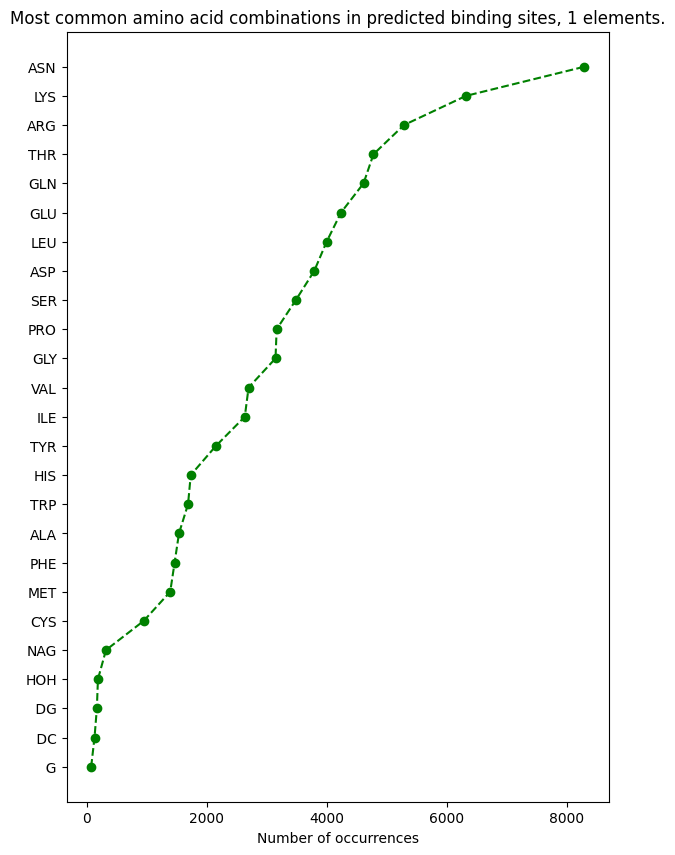

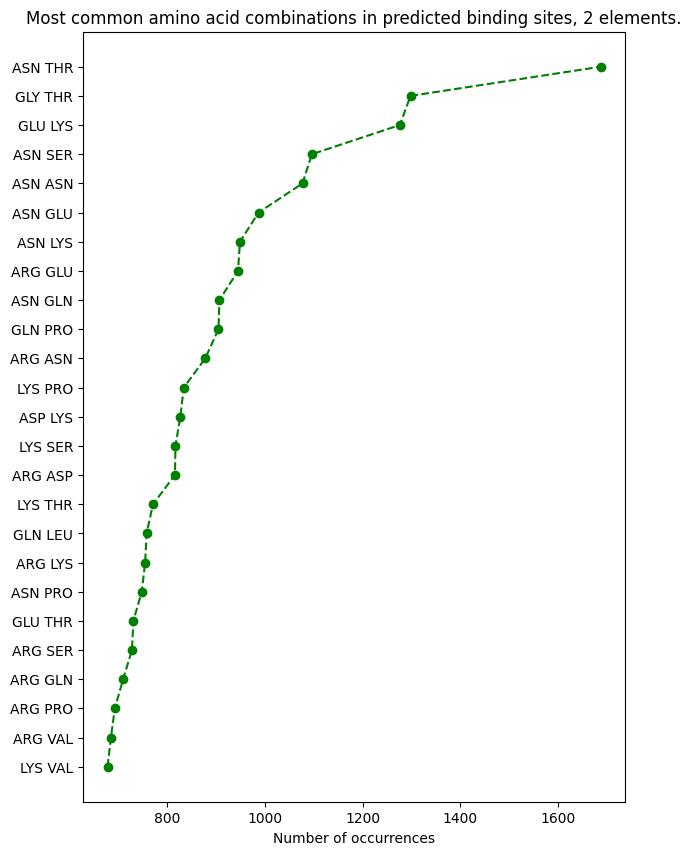

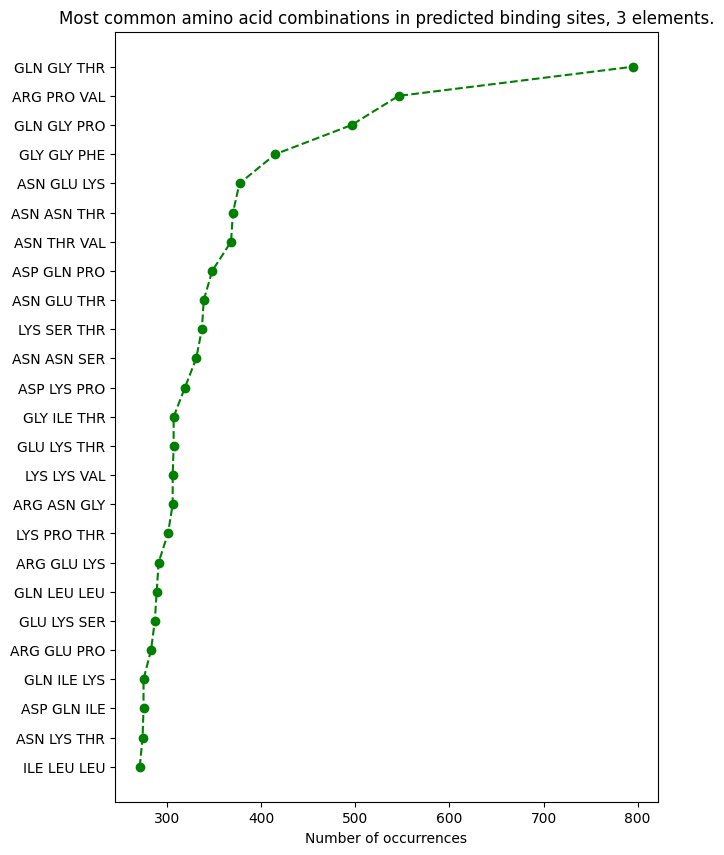

In [21]:
for i in range(0, 5):
    plt.figure(figsize=(7,10))
    ypts = per_bsite_df["top_"+str(i+1)].value_counts()[0:25].values
    xpts = per_bsite_df["top_"+str(i+1)].value_counts()[0:25].index
    plt.plot(np.flip(ypts), np.flip(xpts), '--go')
    plt.title(f"Most common amino acid combinations in predicted binding sites, {i+1} elements.")
    plt.xlabel("Number of occurrences")
    plt.xticks()

In [3]:
path = "./data/stats_virus_out/"
files = os.listdir(path)
#all_AAs=["ALA", "ARG", "ASN", "ASP", "CYS", "GLN", "GLU", "GLY", "HIS", "ILE", "LEU", "LYS", "MET", "PHE", "PRO", "SER", "THR", "TRP", "TYR", "VAL"]
categories = ["pdb_id","chain_id", "bsite_index", "top_AAs", "bsite_hull_volume", "total_hull_volume", "avg_bsite_rasa", "num_bsite_aa", "num_other_aa"]

per_bsite_df = pd.concat([pd.read_csv(path+file, sep="\t")[categories] for file in files])
per_bsite_df = per_bsite_df[per_bsite_df["bsite_hull_volume"]!=0].reset_index().drop("index", axis=1)


In [393]:
per_bsite_df["top_AAs"].value_counts().to_csv("./data/out/top_aa_combinations.csv")

In [394]:
per_bsite_df

pdb_id chain_id  bsite_index                    top_AAs  \
0       4jmy        A            0  ['GLY' 'PRO' 'SER' 'TYR']   
1       4jmy        A            1  ['ALA' 'CYS' 'SER' 'THR']   
2       4itv        D            0  ['ASP' 'GLN' 'LEU' 'PRO']   
3       4itv        I            0  ['ASP' 'GLN' 'GLN' 'PRO']   
4       4jtx        E            0  ['GLN' 'GLN' 'LYS' 'SER']   
...      ...      ...          ...                        ...   
68633   1xr7        A            4  ['LEU' 'LYS' 'PHE' 'TYR']   
68634   1xr7        A            5  ['ARG' 'GLU' 'LYS' 'PRO']   
68635   1xr7        A            6  ['ARG' 'ASP' 'LEU' 'SER']   
68636   1xr7        A            7  ['LEU' 'PHE' 'PRO' 'VAL']   
68637   1xr7        A            8  ['GLU' 'LYS' 'LYS' 'LYS']   

       bsite_hull_volume  total_hull_volume  avg_bsite_rasa  num_bsite_aa  \
0                2459.66           31595.05            0.34            21   
1                3171.84           31595.05            0.46            25   
2                4488.29           97358.46            0.20            31   
3                4683.24           98207.01            0.23            32   
4                1226.22           84234.49            0.41            14   
...                  ...                ...             ...           ...   
68633           11997.80          101066.44            0.26            45   
68634            9778.05          101066.44            0.22            48   
68635           10538.61          101066.44            0.18            63   
68636            8891.05          101066.44            0.30            47   
68637            7055.85          101066.44            0.26            35   

       num_other_aa  
0               161  
1               157  
2               409  
3               408  
4               307  
...             ...  
68633           415  
68634           412  
68635           397  
68636           413  
68637           425  

[68638 rows x 9 columns]

In [395]:
per_bsite_df.to_csv(sep="\t", path_or_buf="./data/out/bsite_stats.csv")

In [398]:
bsite_volumes = per_bsite_df["bsite_hull_volume"]

remainder_volumes =  per_bsite_df["total_hull_volume"] - bsite_volumes

In [399]:
bsite_volumes.mean()/remainder_volumes.mean()*100

4.852796755918524

Text(0, 0.5, 'Angstrom^3')

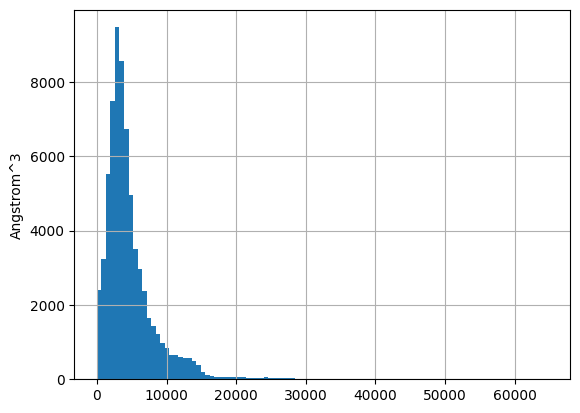

In [400]:
bsite_volumes.hist(bins=100)
plt.ylabel("Angstrom^3")

In [405]:
per_bsite_df[per_bsite_df["avg_bsite_rasa"].isna()]

pdb_id chain_id  bsite_index                    top_AAs  \
63888   6crz        C            7                    ['NAG']   
63893   6crd        B            1              ['MAN' 'MAN']   
63897   6crd        B            8  ['BMA' 'MAN' 'MAN' 'NAG']   
63958   6cs0        C            7                    ['NAG']   

       bsite_hull_volume  total_hull_volume  avg_bsite_rasa  num_bsite_aa  \
63888              21.79          487239.66             NaN             1   
63893              75.78          157220.08             NaN             2   
63897            1600.49          157220.08             NaN             9   
63958              21.79          487239.66             NaN             1   

       num_other_aa  
63888          1068  
63893           445  
63897           438  
63958          1068

In [407]:
per_bsite_df[['num_bsite_aa','num_other_aa', 'avg_bsite_rasa', "bsite_hull_volume", "total_hull_volume"]].describe()

num_bsite_aa  num_other_aa  avg_bsite_rasa  bsite_hull_volume  \
count  68638.000000  68638.000000     68634.00000       68638.000000   
mean      29.735278    342.319896         0.32757        4761.522594   
std       16.629389    204.648407         0.10616        4031.285221   
min        1.000000      0.000000         0.05000           0.140000   
25%       20.000000    228.000000         0.26000        2477.820000   
50%       26.000000    311.000000         0.32000        3705.960000   
75%       35.000000    441.000000         0.38000        5753.600000   
max      188.000000   1636.000000         1.00000       64759.760000   

       total_hull_volume  
count       68638.000000  
mean       102880.665719  
std         85952.718270  
min           116.890000  
25%         56759.750000  
50%         90560.700000  
75%        125850.690000  
max        562489.190000

In [5]:
bstablecopy = per_bsite_df

In [10]:
bstablecopy.sort_values(by = "bsite_hull_volume")

pdb_id chain_id  bsite_index                    top_AAs  \
21533   3hi1        J            5                    ['GLY']   
49810   6rwm        B            5                    ['ALA']   
49412   6rwn        J            6                    ['ALA']   
44239   5t0e        B            2                    ['ALA']   
13692   4bsc        B            3                    ['ALA']   
...      ...      ...          ...                        ...   
54986   5kaq        B            1  ['ASN' 'ASN' 'ILE' 'THR']   
20537   6x4e        A            5  ['ASP' 'ASP' 'GLU' 'HIS']   
38976   5xl2        B            1  ['ASP' 'GLU' 'ILE' 'SER']   
9559    4we1        A            3  ['ARG' 'ASP' 'GLY' 'GLY']   
25726   6waz        A            1  [' DC' 'ASP' 'HIS' 'PRO']   

       bsite_hull_volume  total_hull_volume  avg_bsite_rasa  num_bsite_aa  \
21533               0.14           48970.30            0.83             1   
49810               0.91          111936.41            0.69             1   
49412               0.92          112576.42            0.70             1   
44239               1.41           99784.72            0.46             1   
13692               1.42           90347.21            0.44             1   
...                  ...                ...             ...           ...   
54986           52417.60          128474.61            0.26           127   
20537           53997.94          182252.63            0.27            98   
38976           54482.97          128963.02            0.28           119   
9559            55730.66          170495.27            0.30           102   
25726           64759.76          205268.09            0.29           112   

       num_other_aa  
21533           224  
49810           269  
49412           269  
44239           329  
13692           316  
...             ...  
54986           353  
20537           449  
38976           367  
9559            440  
25726           469  

[68638 rows x 9 columns]

In [11]:
bstablecopy.iloc[25726]

pdb_id                                    6waz
chain_id                                     A
bsite_index                                  1
top_AAs              [' DC' 'ASP' 'HIS' 'PRO']
bsite_hull_volume                     64759.76
total_hull_volume                    205268.09
avg_bsite_rasa                            0.29
num_bsite_aa                               112
num_other_aa                               469
Name: 25726, dtype: object

In [13]:
# import pathlib
# import shutil


# archive = zipfile.ZipFile('/media/s89242079/KEYCHAIN II/bsr_data/restructured/ProBiS_Dock_DB_bs_id1division_id9_restructured.zip')
# PREFIX = '6waz/'
# out = pathlib.Path('./6waz')
# for archive_item in archive.namelist():
#     if archive_item.startswith(PREFIX):
#         # strip out the leading prefix then join to `out`, note that you 
#         # may want to add some securing against path traversal if the zip
#         # file comes from an untrusted source
#         destpath = out.joinpath(archive_item[len(PREFIX):])
#         # make sure destination directory exists otherwise `open` will fail
#         os.makedirs(destpath.parent, exist_ok=True)
#         with archive.open(archive_item) as source:
#             with open(destpath, 'wb') as dest:
#                 shutil.copyfileobj(source, dest)